In [56]:
import numpy as np
import jax.numpy as jnp
import jax

from scipy.optimize import minimize
# from jax.scipy.optimize import minimize

import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm
from scoobpsf.imshows import *

from importlib import reload

Nact = 34
Nacts = 952
act_spacing = 300*u.um

pupil_diam = 6.75*u.mm
npix = 256
oversample = 8
N = int(npix*oversample)
wavelength= 650*u.nm

npsf = 200
psf_pixelscale_lamD = 1/5

from importlib import reload



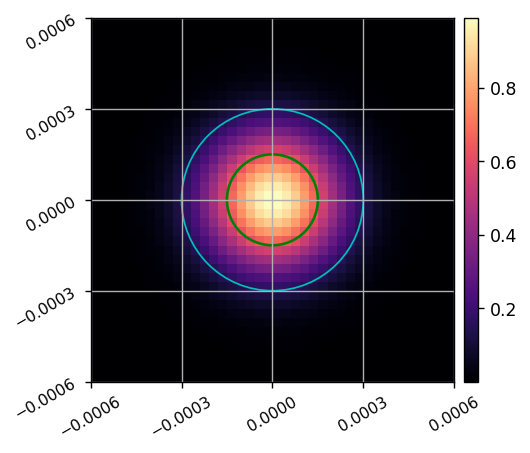

2023-10-15 13:52:18.665879: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:20.818134: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:20.964144: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
2023-10-15 13:52:21.552584: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:21.770827: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


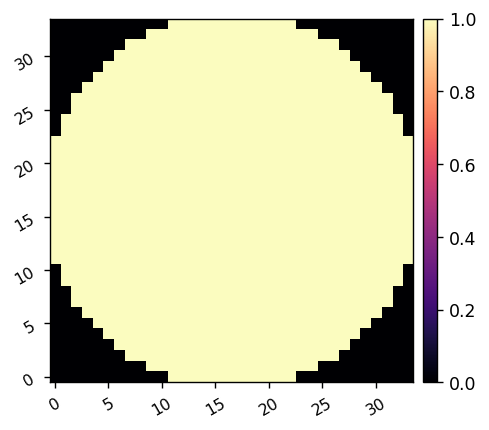

952


In [2]:
reload(jdm)
inf_fun, inf_sampling, inf_pixelscale = jdm.make_gaussian_inf_fun(sampling=10, Nacts_per_inf=4, plot=True)

dm_mask = jdm.make_dm_mask(plot=True)
print(dm_mask.sum())


In [3]:
inf_matrix = jdm.make_inf_matrix(inf_fun, inf_sampling, dm_mask)

2023-10-15 13:52:31.469324: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:32.916605: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.055413: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.130012: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.267892: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.409392: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.550664: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.692596: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:33.834525: E external/o

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


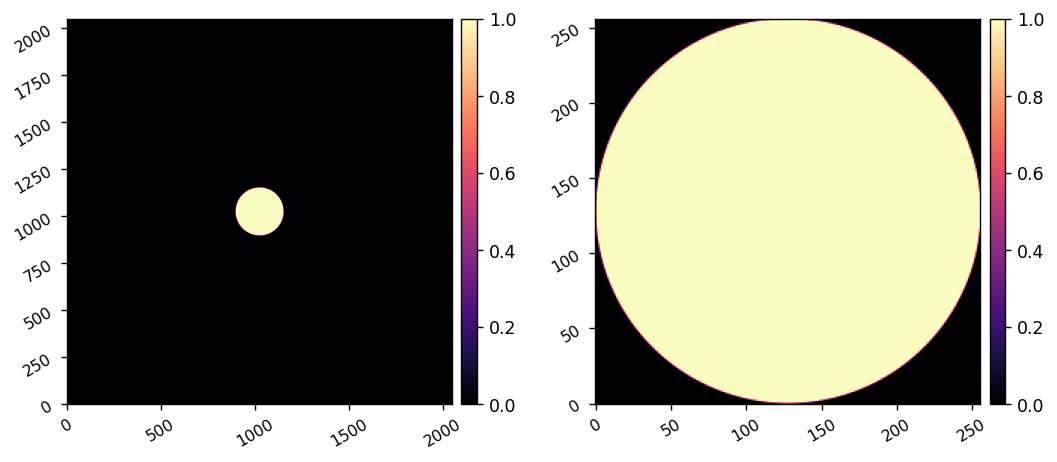

2023-10-15 13:52:47.473323: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-15 13:52:47.787769: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


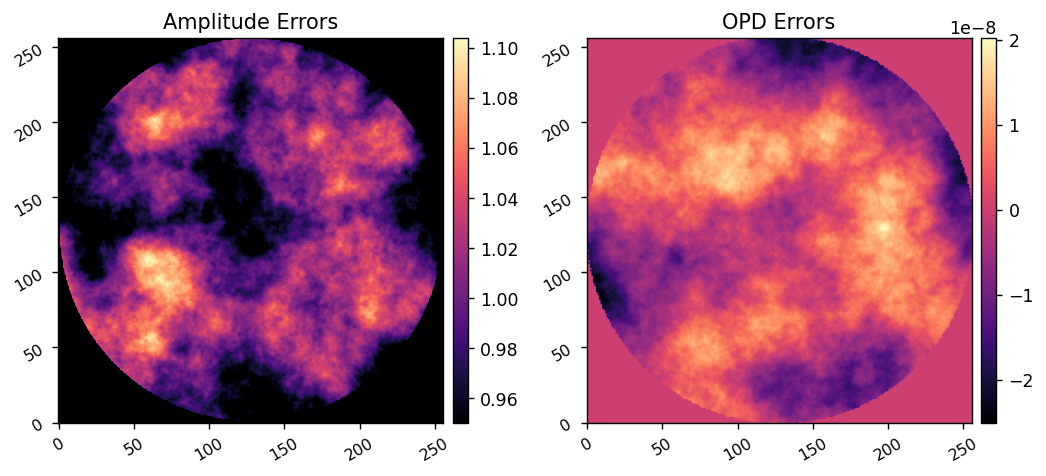

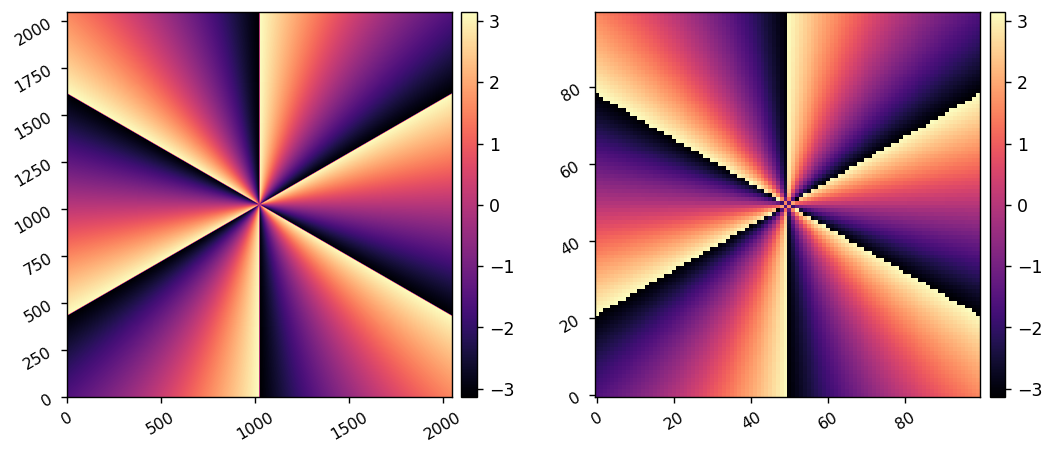

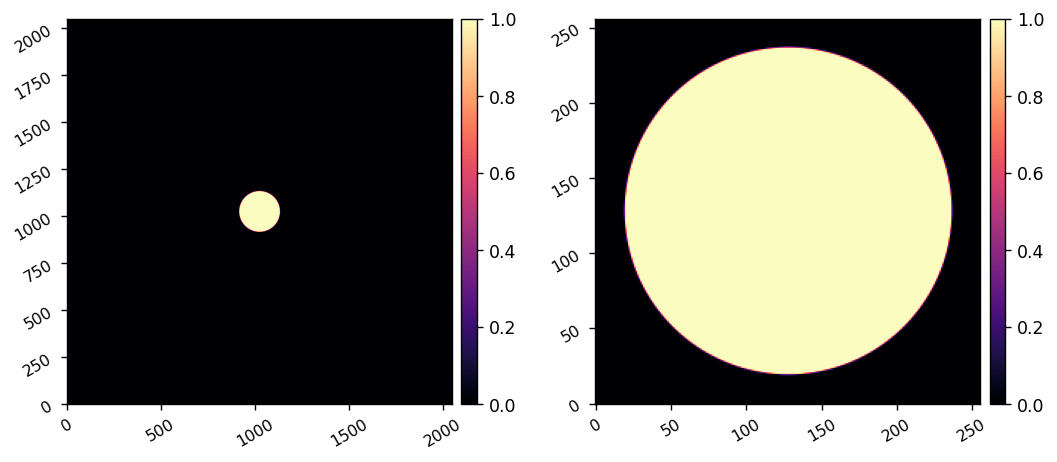

In [4]:
reload(jscoob)

pupil = jscoob.make_pupil(pupil_diam, npix, oversample)
imshow2(pupil, pupil, npix2=npix)

WFE = jscoob.generate_wfe(diam=pupil_diam,
                          # amp_rms=0*u.nm, opd_rms=0*u.nm,
                          amp_rms=0.2*u.nm, amp_index=3.2, opd_rms=20*u.nm, opd_index=3.2,
                          npix=npix, oversample=oversample,)

imshow2(ensure_np_array(jnp.abs(WFE)), ensure_np_array(jnp.angle(WFE))/(2*np.pi)*wavelength.to_value(u.m), 
        'Amplitude Errors', 'OPD Errors',
        npix=npix,
        vmin1=0.95)

focal_grid = jscoob.make_focal_grid(npix,oversample)
vortex = jscoob.make_vortex_phase_mask(focal_grid)
imshow2(jnp.angle(vortex), jscoob.pad_or_crop(jnp.angle(vortex), 100))

lyot = jscoob.make_pupil(pupil_diam, npix, oversample, ratio=0.85)
imshow2(lyot, lyot, npix2=npix)


In [37]:
type(pupil), type(WFE), type(vortex), type(lyot)

(jaxlib.xla_extension.Array,
 jaxlib.xla_extension.Array,
 jaxlib.xla_extension.Array,
 jaxlib.xla_extension.Array)

In [123]:
actuators = jnp.zeros(Nacts)
# actuators = jnp.array(np.random.randn(Nacts))*2e-9
actuators.shape

(952,)

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


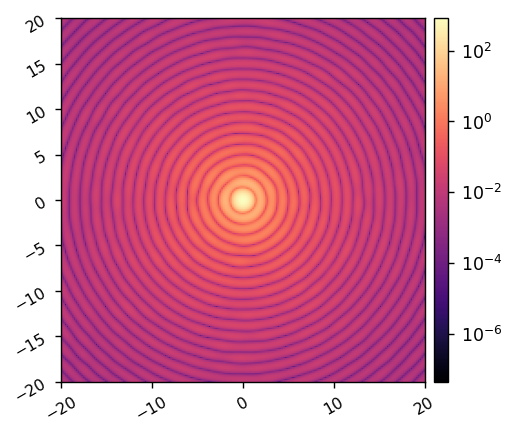

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


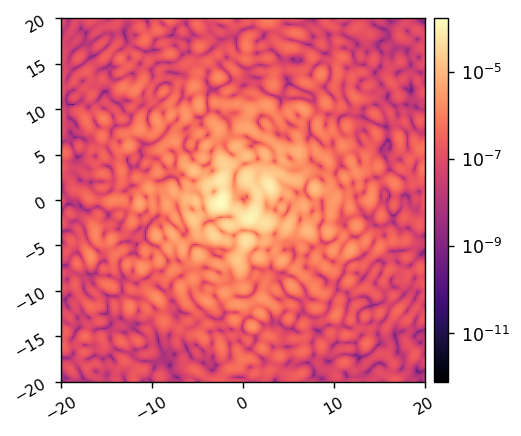

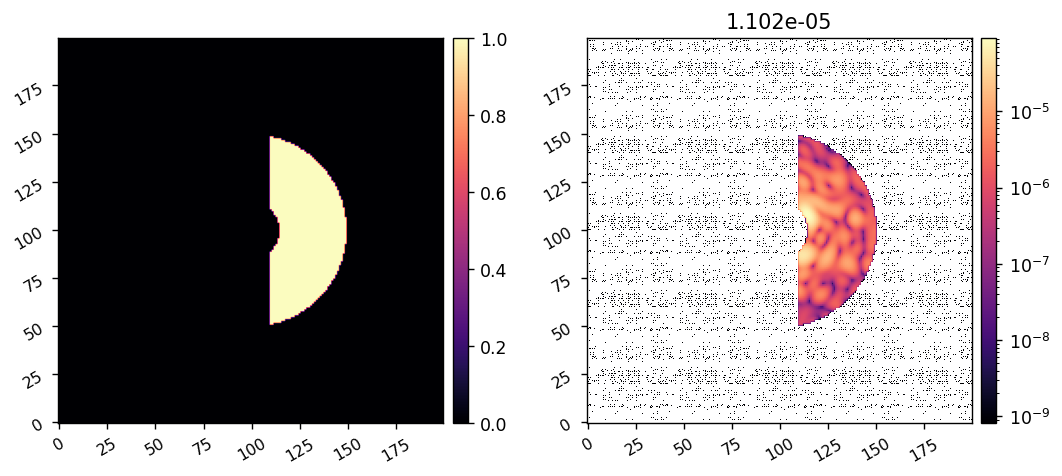

In [124]:
reload(jscoob)
ref_unocc_im = jscoob.snap(pupil, WFE, jnp.ones((N,N)), lyot,
                                    actuators, inf_matrix, inf_pixelscale,
                                    npix, oversample,
                                    plot=True)

Imax_ref = ref_unocc_im.max()

reload(jscoob)
ref_im = jscoob.snap(pupil, WFE, vortex, lyot,
                    actuators, inf_matrix, inf_pixelscale,
                    npix, oversample, Imax_ref=Imax_ref,
                    plot=True)

xim = (jnp.linspace(0, npsf-1, npsf) - npsf/2 +1/2)*psf_pixelscale_lamD
xim, yim = jnp.meshgrid(xim,xim)
rim = jnp.sqrt(xim**2 + yim**2)

control_mask = (rim > 3)*(rim < 10)*(xim>2)
rms_con = jnp.sqrt(jnp.mean(ref_im[control_mask]**2))
imshow2(control_mask, control_mask*ref_im, None, f'{rms_con:.3e}', lognorm2=True)

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


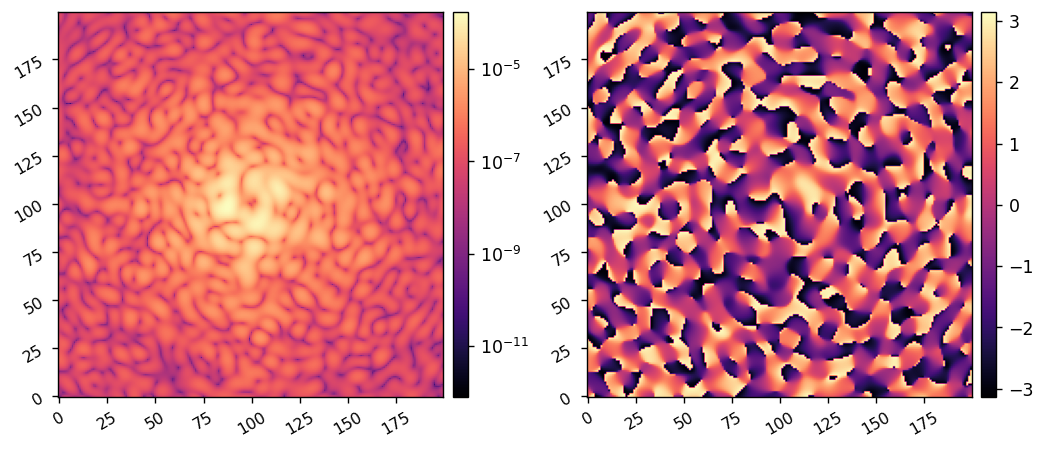

In [125]:
reload(jscoob)

E_ab = jscoob.forward_model(pupil, WFE, vortex, lyot,
                            actuators, inf_matrix, inf_pixelscale,
                            npix, oversample, Imax_ref=Imax_ref)
imshow2(jnp.abs(E_ab)**2, jnp.angle(E_ab), lognorm1=True)



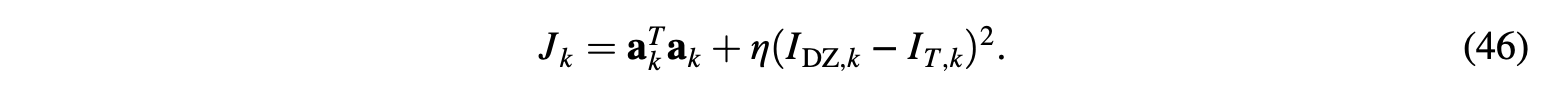

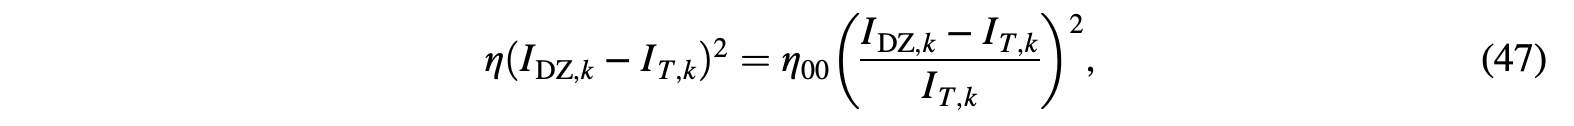

In [134]:
# def cost_fun(acts, I_tar_ratio=1/2, eta_00=1):
#     E_ab = compute_E_ab(model, acts)
#     E_DZ = E_ab[control_mask]
#     I_DZ = jnp.abs(E_DZ.conj().dot(E_DZ))
#     I_tar = I_tar_ratio * I_DZ
#     J = acts.T.dot(acts) + eta_00 * ((I_DZ - I_tar)/I_tar)**2
#     return J

def compute_E_DM(actuators):
    # E0 = jscoob.forward_model(pupil, WFE, vortex, lyot,
    #                           jnp.zeros(Nacts), inf_matrix, inf_pixelscale,
    #                           npix, oversample, Imax_ref=Imax_ref)
    
    # E_with_DM = jscoob.forward_model(pupil, WFE, vortex, lyot,
    #                           actuators, inf_matrix, inf_pixelscale,
    #                           npix, oversample, Imax_ref=Imax_ref)
    # E_DM = E_with_DM - E0

    E_DM = jscoob.forward_model(pupil, jnp.ones((N,N),dtype=jnp.complex128), vortex, lyot,
                              actuators, inf_matrix, inf_pixelscale,
                              npix, oversample, Imax_ref=Imax_ref)

    return E_DM

def cost_fun(actuators, I_tar_ratio=1/2, eta_00=1,):
    '''
    acts: the actuator vector we want to find an optimal solution for
    I_tar_ratio: ratio for the desired target irradiance based on current integrated irradiance
    eta_00: parameter that Scott understands more
    E_ab: current electric-field estimate
    '''
    E_DM = compute_E_DM(actuators)[control_mask]
    E_DZ = E_ab[control_mask] + E_DM
    # print(E_ab[control_mask])
    I_DZ = jnp.abs(E_DZ.conj().dot(E_DZ))
    I_tar = I_tar_ratio * I_DZ
    J = actuators.T.dot(actuators) + eta_00 * ((I_DZ - I_tar)/I_tar)**2
    return J


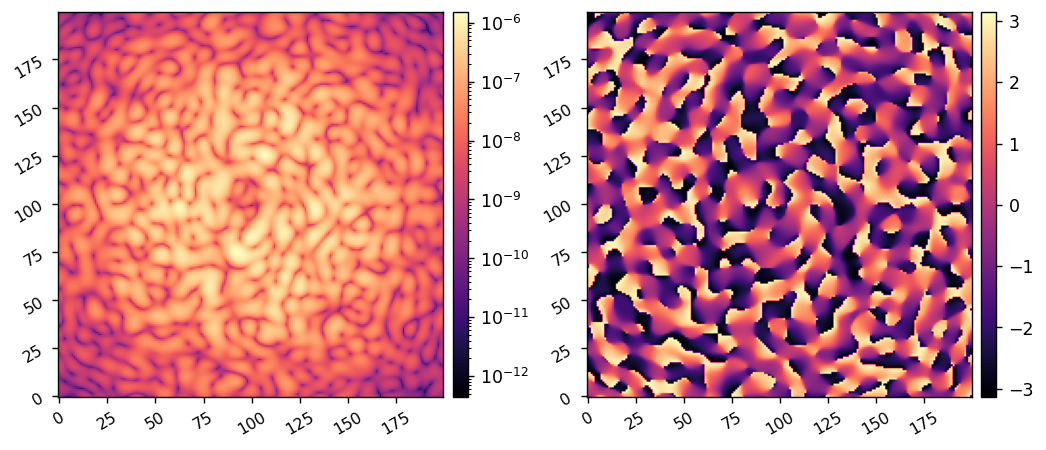

0.14693877551020437


In [135]:
actuators = jnp.array(np.random.randn(Nacts))*0.5e-9
E_DM_2 = compute_E_DM(actuators)
imshow2(jnp.abs(E_DM)**2, jnp.angle(E_DM), lognorm1=True)

print(cost_fun(actuators, I_tar_ratio=0.7, eta_00=0.8))

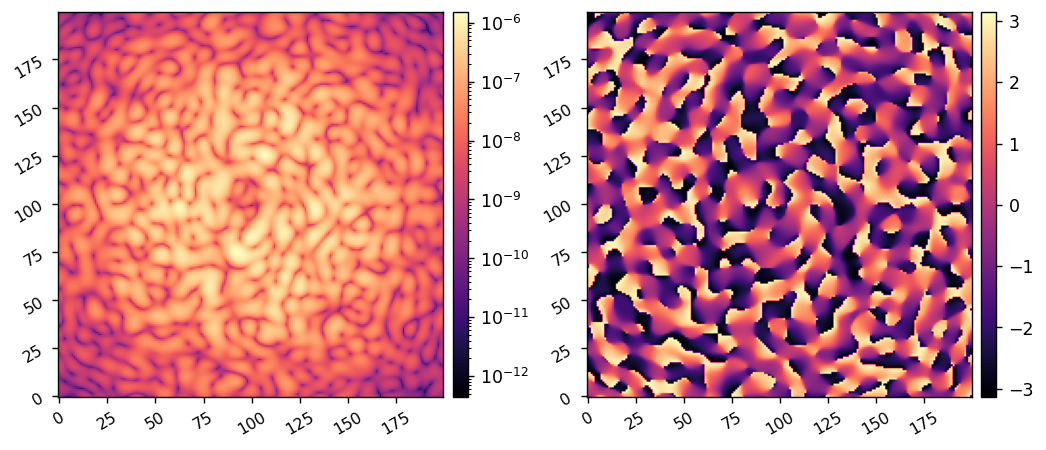

0.14693877551020446


In [133]:
actuators = jnp.array(np.random.randn(Nacts))*0.5e-9
E_DM = compute_E_DM(actuators)
imshow2(jnp.abs(E_DM)**2, jnp.angle(E_DM), lognorm1=True)

print(cost_fun(actuators, I_tar_ratio=0.7, eta_00=0.8))


1.0000000000000002 (952,)


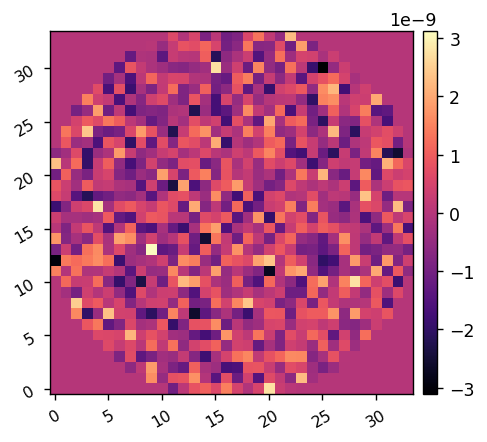

In [129]:
value_and_grad_of_cost = jax.value_and_grad(cost_fun)

val_and_grad = value_and_grad_of_cost(actuators)
print(val_and_grad[0], val_and_grad[1].shape)
grad_command = jdm.map_actuators_to_command(val_and_grad[1], dm_mask)
imshow1(grad_command)
# print(val_and_grad[1])

In [130]:
del_acts0 = jnp.zeros(Nacts)

In [131]:
from scipy.optimize import minimize
res = minimize(value_and_grad_of_cost, x0=del_acts0, 
         jac=True,
         method='L-BFGS-B', 
         tol=1e-3,
         options={'disp':True},
        )

RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.00788D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  952      0      1      0     0     0   8.008D-09   1.000D+00
  F =   1.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


True (952,)


2023-10-15 14:54:56.669533: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


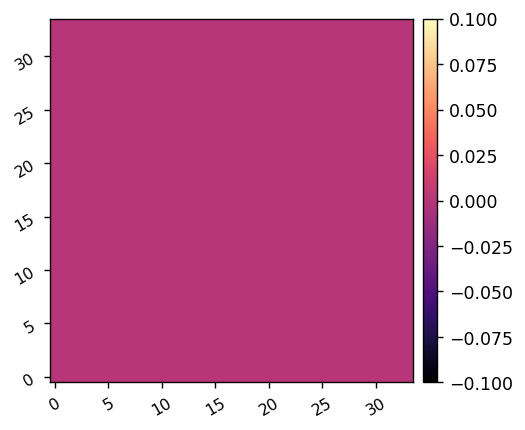

In [99]:
print(res.success, res.x.shape)
command = jdm.map_actuators_to_command(res.x, dm_mask)
imshow1(command)

In [90]:
from jax.scipy.optimize import minimize
res = minimize(cost_fun, 
                x0=del_acts0, 
                method='BFGS', 
                tol=1e-3,
        )

True (952,)


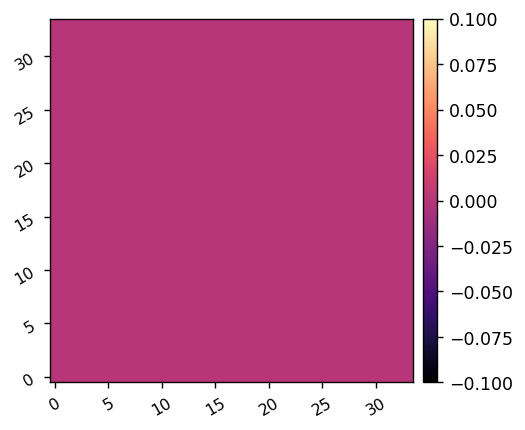

In [97]:
print(res.success, res.x.shape)
command = jdm.map_actuators_to_command(res.x, dm_mask)
imshow1(command)